In [88]:
# importing libraries

import torch.nn as nn
import torchvision
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split,Dataset,SubsetRandomSampler
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import os
import numpy as np

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:31<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [87]:
import shutil

# final dataset path
final_path = "/content/data/malaria"
if not os.path.exists(final_path):
    shutil.move(path, final_path)

print("Dataset moved to:", final_path)


Dataset moved to: /content/data/malaria


In [85]:
# Define paths
src_path = "/content/data/malaria/cell_images"
dst_path = "/content/data/malaria"

# Check if 'cell_images' exists
if os.path.exists(src_path):
    for folder in ["Parasitized", "Uninfected"]:
        shutil.move(os.path.join(src_path, folder), dst_path)
    shutil.rmtree(src_path)
    print("Dataset fixed! Images moved to:", dst_path)
else:
    print("No 'cell_images' folder found. Check dataset path.")


No 'cell_images' folder found. Check dataset path.


In [16]:
!ls /content/data/malaria

Parasitized  Uninfected


In [17]:
from torchvision import datasets, transforms

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root="/content/data/malaria", transform=transform)

print(f"Total Images: {len(dataset)}")
print(f"Classes: {dataset.classes}")


Total Images: 27558
Classes: ['Parasitized', 'Uninfected']


In [18]:
# splitting the dataset

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [19]:
valid_pct = 0.2
test_pct = 0.1

In [21]:
data_len = len(dataset)
data_indices = list(range(data_len))
np.random.shuffle(data_indices)

valid_split = int(np.floor((valid_pct) * data_len))
test_split = int(np.floor((valid_pct + test_pct) * data_len))

valid_idx, test_idx, train_idx = data_indices[:valid_split], data_indices[valid_split:test_split], data_indices[test_split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=64, sampler=train_sampler),
    'valid': torch.utils.data.DataLoader(dataset, batch_size=32, sampler=valid_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=20, sampler=test_sampler)
}

print(len(valid_idx), len(test_idx), len(train_idx))

5511 2756 19291


In [22]:
invTrans = transforms.Compose([ transforms.Normalize([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize([ -0.485, -0.456, -0.406 ],[ 1., 1., 1. ]),
                               ])

def imshow(img):
    img = invTrans(img)
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [23]:
# Create the 'plots' directory
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/data_vis.png')

<Figure size 640x480 with 0 Axes>

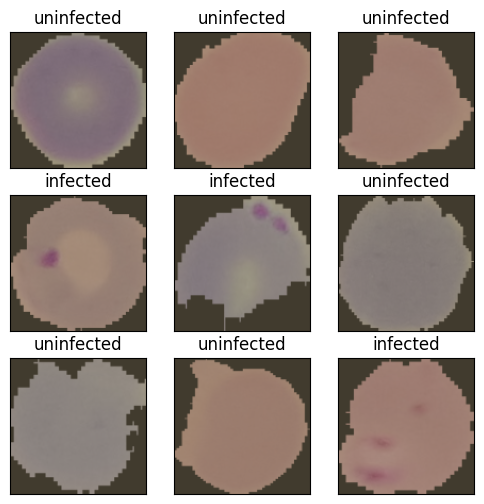

In [24]:
classes=['infected','uninfected']

dataiter = iter(dataloaders['train'])
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()

fig = plt.figure(figsize=(6, 6))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.savefig('plots/data_vis.png')

In [58]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16384, 500),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


model_scratch = Net()
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
  

In [59]:
criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=0.001, weight_decay=1e-4)


In [60]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker
    valid_loss_min = np.Inf
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        valid_loss = 0.0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

    # return trained model
    return model, train_losses, val_losses

In [61]:
def forward(self, x):
    out = self.layer1(x)
    print("Shape before flattening:", out.shape)
    out = out.view(out.shape[0], -1)
    print("Shape after flattening:", out.shape)
    out = self.fc(out)
    return out


In [62]:
model_path = 'models/model_scratch-img64.pt'

os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model
torch.save(model_scratch.state_dict(), model_path)
print("Model saved successfully!")


Model saved successfully!


In [63]:
import torch

def train_with_early_stopping(num_epochs, dataloaders, model, optimizer, criterion, device, save_path, patience=5):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        val_loss = ...

        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            print("Saving best model..")
            torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


In [64]:
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# train the model
model_scratch, train_losses, val_losses = train(20, dataloaders, model_scratch, optimizer_scratch,
                                                criterion_scratch, device, 'models/model_scratch-img64.pt')

Epoch: 1 	Training Loss: 0.376309 	Validation Loss: 0.167865
Saving model..
Epoch: 2 	Training Loss: 0.158608 	Validation Loss: 0.139273
Saving model..
Epoch: 3 	Training Loss: 0.140595 	Validation Loss: 0.146858
Epoch: 4 	Training Loss: 0.129887 	Validation Loss: 0.136766
Saving model..
Epoch: 5 	Training Loss: 0.119253 	Validation Loss: 0.131185
Saving model..
Epoch: 6 	Training Loss: 0.111393 	Validation Loss: 0.123834
Saving model..
Epoch: 7 	Training Loss: 0.104488 	Validation Loss: 0.126150
Epoch: 8 	Training Loss: 0.100640 	Validation Loss: 0.126365
Epoch: 9 	Training Loss: 0.095536 	Validation Loss: 0.126644
Epoch: 10 	Training Loss: 0.089141 	Validation Loss: 0.144213
Epoch: 11 	Training Loss: 0.086049 	Validation Loss: 0.133641
Epoch: 12 	Training Loss: 0.076172 	Validation Loss: 0.140735
Epoch: 13 	Training Loss: 0.075294 	Validation Loss: 0.150417
Epoch: 14 	Training Loss: 0.064829 	Validation Loss: 0.171818
Epoch: 15 	Training Loss: 0.059204 	Validation Loss: 0.165388
Epoc

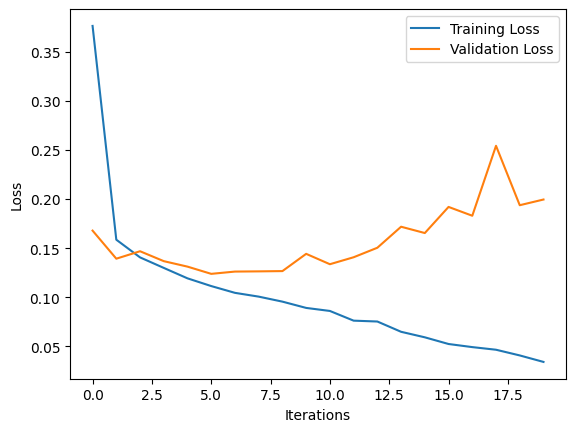

In [65]:
if not os.path.exists('Plots'):
    os.makedirs('Plots')

plt.plot([t.cpu().item() for t in train_losses], label = 'Training Loss')
plt.plot([t.cpu().item()  for t in val_losses], label = 'Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_= plt.ylim()

plt.savefig('Plots/Training Validation Loss with CNN from scratch.png')
plt.show()

In [66]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('models/model_scratch-img64.pt'))

<ipython-input-66-d4a88c2621bc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_scratch.load_state_dict(torch.load('models/model_scratch-img64.pt'))


<All keys matched successfully>

In [67]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))

    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):

        data, target = data.to(device), target.to(device)

        # forward pass:
        output = model(data)
        # loss
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())

        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return y, y_hat

In [68]:
# call test function
y, y_hat = test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 0.137759


Test Accuracy: 95% (2643/2756)


In [89]:
# my_ml_lib.py
class MetricTools:
    @staticmethod
    def confusion_matrix(*args, **kwargs):
        print("MetricTools.confusion_matrix called with args:", args, kwargs)


class PlotTools:
    @staticmethod
    def confusion_matrix(*args, **kwargs):
        print("PlotTools.confusion_matrix called with args:", args, kwargs)

In [73]:
cm = MetricTools.confusion_matrix(y, y_hat, nclasses=2)

MetricTools.confusion_matrix called with args: (array([1, 0, 0, ..., 0, 1, 1]), array([1, 1, 0, ..., 0, 1, 1])) {'nclasses': 2}


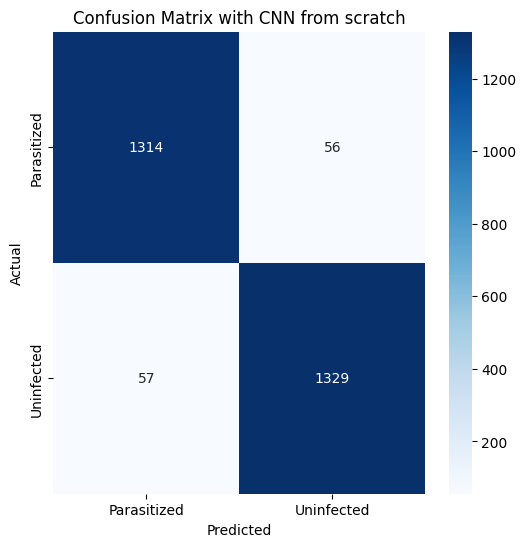

In [78]:
# Confusion Matrix
cm = confusion_matrix(y, y_hat)

# Plot
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with CNN from scratch')
plt.savefig('plots/confusion_matrix.png')
plt.show()


In [79]:
PlotTools.confusion_matrix(cm, ['Parasitized', 'Uninfected'], title='',
                           filename='Confusion Matrix with CNN from scratch', figsize=(6,6), path='plots/')

PlotTools.confusion_matrix called with args: (array([[1314,   56],
       [  57, 1329]]), ['Parasitized', 'Uninfected']) {'title': '', 'filename': 'Confusion Matrix with CNN from scratch', 'figsize': (6, 6), 'path': 'plots/'}


In [82]:
from sklearn.metrics import precision_score, recall_score

# precision and recall
prec = precision_score(y, y_hat, average='macro')
rec = recall_score(y, y_hat, average='macro')

#  F1-score
f1 = 2 * (prec * rec) / (prec + rec)

print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

Precision: 0.9590, Recall: 0.9590, F1-score: 0.9590


In [83]:
np.around([prec, rec, f1], 3),

(array([0.959, 0.959, 0.959]),)